In [19]:
#!/usr/bin/python
%matplotlib inline

import numpy as np
#import matplotlib; matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import time
from scipy.misc import comb
from scipy import stats
import scipy.interpolate

rez=600

t_list=[1.1, 6.8, 12, 1.1, 4.1, 11.8, 1.8, 8.2, 12.3]

#reservoir size, assumes start with 1e6
L_list=[811573.76223245775, 275094.66615200648, 102529.98362597442,
        811573.76223245775, 459241.06991863332, 106496.83634016832,
        710603.97609896038, 210902.36030001106, 96855.025592542122]

marker_list=['o', 'o', 'o', 's', 's', 's', '^', '^', '^']
color_list=['navy','slateblue','steelblue', 
            'darkgreen','olivedrab', 'limegreen',
            'pink', 'peru','tomato']

xlabs=[r'exponential $\beta$',r'linear $m$',r'power law $\alpha$']

#list of observed abundances
q_list = [
    np.array([ 5.,  3.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.]),
    np.array([ 5.,  4.,  3.,  3.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
    np.array([ 4.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.]),
    np.array([ 7.,  7.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
    np.array([ 9.,  3.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.]),
    np.array([ 9.,  3.,  3.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
    np.array([ 3.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
    np.array([ 5.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.]),
    np.array([ 4.,  4.,  3.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
     ]
     

#chao estimates
Rest = np.array([348.33333333, 317.12747253, 132.84330484, 
                 358.77777778, 296.37209302, 193.01666667,
                 5554.84615385, 598.30967742, 458.21311475])

Rstd = np.array([194.1313988 ,  210.9316196 ,   55.04443701,
                 543.52920805,  449.03201445,  168.55275509,
                 8.71779789,  533.38450601,  405.93533968])

def choose_approx(n,k):
    return (np.exp(1)*n/k)**k

def Stirling(x):
    return x*np.log(x)-x

#function that calculates rarefaction curve based on rank and abundance data
def rarefaction(rank,abundance,num_samples):

    R=len(abundance)
    L=sum(abundance)

    r_list=np.zeros(num_samples)
    n_list=range(0,num_samples)
    for n in n_list:
        ss=0 #the sum
        for j in range(R):
            #ss+=comb(L-abundance[j],n)
            ss+=choose_approx(L-abundance[j],n)
            
        #r_list[n]=R-ss/comb(L,n)
        r_list[n]=R-ss/choose_approx(L,n)
    return n_list,r_list

#function that calculates rarefaction curve based on rank and abundance data
def rarefaction_approx(rank,abundance,num_samples):

    R=len(abundance)
    L=sum(abundance)

    r_list=np.zeros(num_samples)
    n_list=range(1,num_samples+1)
    for n in n_list:
        r_list[n-1]=R-np.sum((1-abundance/L)**n)
    return n_list,r_list

#species accumulation
def accumulate(dist,max_s):
    s_list=[]
    s=0
    curve=[]
    while s<max_s:
        draw = model.sample_distribution(dist,1)[0]

        if draw not in s_list:
            s+=1

        s_list.append(draw)
        curve.append(s)
    
    return np.arange(1,len(curve)+1),np.array(curve)

In [2]:
#print some information about the data for tex table:
print(r'time (yrs) & # samples & max rank & rank1 frac & unique frac \\')
for i in range(9):
    #plt.scatter(range(1,len(q_list[i])+1),np.cumsum(q_list[i]))
    print(t_list[i],'&       ',sum(q_list[i]),'&    ',len(q_list[i]),
          '&    ',max(q_list[i])/sum(q_list[i]),'&',sum(q_list[i]==1)/sum(q_list[i]),r'\\')



time (yrs) & # samples & max rank & rank1 frac & unique frac \\
1.1 &        68.0 &     58 &     0.0735294117647 & 0.764705882353 \\
6.8 &        65.0 &     51 &     0.0769230769231 & 0.676923076923 \\
12 &        54.0 &     43 &     0.0740740740741 & 0.648148148148 \\
1.1 &        48.0 &     35 &     0.145833333333 & 0.666666666667 \\
4.1 &        43.0 &     32 &     0.209302325581 & 0.674418604651 \\
11.8 &        48.0 &     34 &     0.1875 & 0.604166666667 \\
1.8 &        78.0 &     76 &     0.0384615384615 & 0.961538461538 \\
8.2 &        62.0 &     56 &     0.0806451612903 & 0.854838709677 \\
12.3 &        61.0 &     51 &     0.0655737704918 & 0.754098360656 \\


In [7]:
#the cdf statistics, for liklihood calculation

q_len=32 #max rank of shortest cdfs

q_mat=np.zeros([9,q_len])
for i in range(9):
    q_mat[i,:]=q_list[i][:q_len]
    
r_avg=np.arange(1,q_len+1)

pdf_avg=np.mean(q_mat,0)
pdf_std=np.std(q_mat,0)

cdf_avg=np.mean(np.cumsum(q_mat,1),0)
cdf_std=np.std(np.cumsum(q_mat,1),0)



In [26]:
pdf_std

array([ 2.05480467,  1.56347192,  0.62853936,  0.66666667,  0.49690399,
        0.47140452,  0.41573971,  0.31426968,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

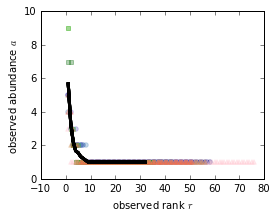

In [16]:
plt.figure(figsize=(4,3),dpi=rez)
for i in range(9):
    plt.scatter(np.arange(1,len(q_list[i])+1),q_list[i],marker=marker_list[i],color=color_list[i],alpha=0.3)
    plt.plot(r_avg,pdf_avg,lw=3,color='k')

plt.xlabel('observed rank $r$')
plt.ylabel('observed abundance $a$')

In [83]:
#A model for the abundance distribution of the HIV reservoir
class ra_model(object):

    #initialize
    def __init__(self, number, model_type, u_max, r_max, parameter, L=0, ufrac=0, richness=0, error_list=[], dist=0):
        self.number = number
        self.parameter = parameter
        self.u_max = u_max
        self.r_max = r_max
        self.model_type = model_type
        self.L = L
        self.ufrac = ufrac
        self.richness = richness
        self.error_list = []
        
    #build the distribution
    def make_distribution(self):
        
        if self.model_type=='exp':
            dist = np.flipud(np.append(np.ones(self.u_max),np.exp(np.arange(1,self.r_max)*self.parameter)))

        if self.model_type=='lin':
            dist = np.flipud(np.append(np.ones(self.u_max),self.parameter*np.arange(1,self.r_max)))

        if self.model_type=='plw':
            a0=self.r_max**self.parameter
            dist = np.append(a0*np.arange(1,self.r_max)**-self.parameter,np.ones(self.u_max))

        self.L=sum(dist) #size of reservoir
        self.ufrac=sum(dist==1)/self.L #fraction unique in reservoir
        self.richness=len(dist) #richness of reservoir, number of species

        return dist

    #generate random samples from distribution
    def sample_distribution(self,dist,num_samples):
        custm = stats.rv_discrete(name='custm', values=(np.arange(1,len(dist)+1), dist/sum(dist)))
        sim_samples = custm.rvs(size=num_samples)
        return sim_samples
    
    #function that arranges samples into rank abundance
    def rank_model(self,dist,num_samples): 
        samples=self.sample_distribution(dist,num_samples)
        binned = np.bincount(samples)
        #abund=-np.sort(-binned) #the rank abundance data
        abund=-np.sort(-binned[binned != 0]) #the rank abundance data without zeros
        rank=np.arange(1,len(abund)+1)
        return rank,abund

    #calculate the combined error of cdf and chao
    def compute_model(self,dist,pat):                        
        
        data_abund=q_list[pat]
        data_rank=np.arange(1,len(data_abund)+1)
        
        sim_rank,sim_abund=self.rank_model(dist,num_samples=int(sum(data_abund)))

        data_cdf = np.cumsum(data_abund); sim_cdf = np.cumsum(sim_abund); #make cdfs
        
        error=self.error_list[pat]
        
        return data_rank,data_abund,data_cdf,sim_rank,sim_abund,sim_cdf,error
    
    #calculate all errors for all patients
    def calculate_all_errors(self,dist,num_avgs=1):                        
        for pat in range(9):
            data_abund=q_list[pat]
            data_rank=np.arange(1,len(data_abund)+1)
        
            lik_pdf=0; lik_L=0; lik_chao=0;
            
            #KS=0;  pct_err_Chao=0; pct_err_KS=0; pct_err_L=0
            #get an average error over samples
            for j in range(num_avgs):

                sim_rank,sim_abund=self.rank_model(dist,num_samples=int(sum(data_abund)))

                #data_cdf = np.cumsum(data_abund); sim_cdf = np.cumsum(sim_abund); #make cdfs

                #deal with the fact that the ranks aren't the same length
                min_len = min(len(data_abund),len(sim_abund))

                #different error metrics
                #KS+=np.max(np.abs(sim_cdf[:min_len]-data_cdf[:min_len])) #calculate kolmogorov smirnov statistic
                
                #calculate loglik of cdf and L size
                lik_pdf=np.sum(np.log10(stats.norm.pdf(sim_abund[:min_len],data_abund[:min_len],1)))
                lik_L=np.log10(stats.norm.pdf(np.log10(self.L),6,1)) 
                lik_chao=np.log10(stats.norm.pdf(self.richness,Rest[pat],Rstd[pat])) 

                #pct_err_KS+=np.max(np.abs(sim_cdf[:min_len]-data_cdf[:min_len]))/np.max(data_cdf[:min_len])
                
                #pct_err_L+=np.abs(np.log10(self.L)-6)/6
                
                #pct_err_Chao+=np.abs(np.log10(self.richness)-np.log10(Rest[pat]))/np.log10(Rest[pat]) #calculate log chao error

            #pct_err_tot=(pct_err_Chao+pct_err_KS+pct_err_L)/3
            
            self.error_list.append(lik_pdf+lik_L+lik_chao)

    def populate_model(self,num_avgs=1):
        self.calculate_all_errors(self.make_distribution(),num_avgs) #compare with data to calculate errors


exponential error is -24.7657561079
linear error is -23.3273508738
power law

/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in log10
/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:82: RuntimeWarning: divide by zero encountered in double_scalars


 error is -36.1957433469


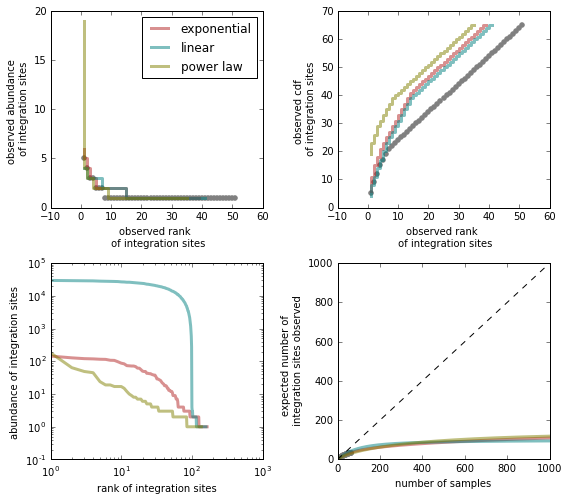

In [84]:
#heres an example
colorz=['firebrick','teal','olive']
titz=['exponential','linear','power law','data']

bt=0.05; al=1.1; m=300; u=100; r=100

test_model_list=[
        ra_model(number=1,model_type='exp',u_max=u,r_max=r,parameter=bt),
        ra_model(number=2,model_type='lin',u_max=u,r_max=r,parameter=m),
        ra_model(number=3,model_type='plw',u_max=u,r_max=r,parameter=al)
            ]

fig=plt.figure(figsize=(8,7),dpi=rez)

pat=1

num_rare_samples=1000

#loop through 3 model types
for i in range(3):
    
    model = test_model_list[i]
    
    dist=model.make_distribution()
    
    model.populate_model(num_avgs=1)
    
    data_rank,data_abund,data_cdf,sim_rank,sim_abund,sim_cdf,error=model.compute_model(dist,pat)
    
    print(titz[i],'error is', error)
    
    rank,abund=model.rank_model(dist,num_samples=int(model.L))

    sim_nrare,sim_rare=rarefaction_approx(rank,abund,num_samples=num_rare_samples)

    plt.subplot(221)
    plt.step(sim_rank,sim_abund,color=colorz[i],lw=3,alpha=0.5)
    plt.xlabel('observed rank \n of integration sites')
    plt.ylabel('observed abundance \n of integration sites')
    
    plt.subplot(222)
    plt.step(np.arange(1,len(sim_cdf)+1),sim_cdf,color=colorz[i],lw=3,alpha=0.5)
    plt.xlabel('observed rank \n of integration sites')
    plt.ylabel('observed cdf \n of integration sites')
    
    plt.subplot(223)
    plt.loglog(rank,abund,color=colorz[i],lw=3,alpha=0.5)
    plt.xlabel('rank of integration sites')
    plt.ylabel('abundance of integration sites')
    plt.ylim([0.1,1e5])
    
    plt.subplot(224)
    plt.plot(sim_nrare,sim_rare,color=colorz[i],lw=3,alpha=0.5)
    plt.xlabel('number of samples')
    plt.ylabel('expected number of  \n integration sites observed')
    plt.xlim([0,sim_nrare[-1]])
    plt.ylim([0,sim_nrare[-1]])
    
plt.subplot(221)
plt.legend(titz)
plt.scatter(data_rank,data_abund,marker='o',color='gray')
plt.subplot(222)
plt.scatter(np.arange(1,len(data_cdf)+1),data_cdf,marker='o',color='gray')

data_nrare,data_rare=rarefaction(data_rank,data_abund,num_samples=int(sum(data_abund)))
plt.subplot(224)
plt.scatter(data_nrare,data_rare,marker='o',color='gray')
plt.plot(np.arange(0,sim_nrare[-1]),np.arange(0,sim_nrare[-1]),ls='--',color='k')

plt.tight_layout()
    


In [60]:
model = test_model_list[i]


In [61]:
    dist=model.make_distribution()


In [62]:
    model.populate_model(num_avgs=1)


/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:88: RuntimeWarning: divide by zero encountered in log10


In [59]:
rank,abund=model.rank_model(dist,num_samples=int(model.L))


In [53]:
numz=5 #how many of each variable to try

p_range_list=[np.logspace(-3,-1,numz), np.logspace(1,4,numz), np.linspace(0.1,1.5,numz)] #exp,lin,plw

u_list=np.round(np.logspace(2,4.5,numz))

#initialize stuff
model_list=[[],[],[]]

min_L=1e5; max_L=1e7

NA=1

model_index=0
#make ALL THE MODELS and compute their errors
print('exponential models')
for bt in p_range_list[0]:
    t = time.time()
    for u in u_list:
        rf=np.log10(1/bt*(max_L-u))
        r_list=np.logspace(0,rf,numz) #range r=[1,rmax]
        for r in r_list:
            model=ra_model(number=model_index,model_type='exp',u_max=u,r_max=r,parameter=bt)
            model.populate_model(num_avgs=NA)
            model_list[0].append(model)
            print(r_list)
    print(time.time() - t)

    
'''print('linear models')
for m in p_range_list[1]:
    t = time.time()
    for u in u_list:
        ri=np.log10(min_L-u)
        rf=np.log10(1/m*(max_L-u))
        r_list=np.logspace(ri,rf,numz)
        for r in r_list:
            model=ra_model(number=model_index,model_type='lin',u_max=u,r_max=r,parameter=m)
            model.populate_model(num_avgs=NA)
            model_list[1].append(model)
    print(time.time() - t)
         
print('powerlaw models')
for al in p_range_list[2]:
    t = time.time()
    for u in u_list:
        ri=np.log10(min_L-u)
        rf=np.log10(1/al*np.log(max_L-u))
        #print(rf)
        r_list=np.logspace(ri,rf,numz)
        for r in r_list:
            model=ra_model(number=model_index,model_type='plw',u_max=u,r_max=r,parameter=al)
            model.populate_model(num_avgs=NA)
            model_list[2].append(model)
    print(time.time() - t)
'''     



/Users/danielreeves/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:87: RuntimeWarning: divide by zero encountered in log10


exponential models
[  9.99000000e+04   1.77694109e+06   3.16068032e+07   5.62196471e+08
   9.99990000e+09]

/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:88: RuntimeWarning: divide by zero encountered in log10
/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in exp


/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

/Users/danielreeves/anaconda/lib/python3.5/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


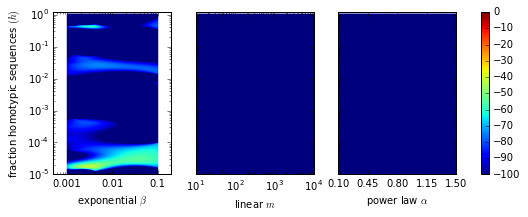

In [46]:
#fill up the best model parameters and plot a heatmap for 1 patient
best_m_list=[[],[],[]] #list of best models

patients=range(9); pat_to_plot=1

#plot all the heatmaps for each patient
fig, ax = plt.subplots(1,3,figsize=(8, 3),dpi=rez,sharey=True)
for pat in patients:
    p=[[],[],[]]; u=[[],[],[]]; err=[[],[],[]]; L_list=[[],[],[]]; m_list=[[],[],[]] 
    #3 types of models, process data
    for i in range(3):
        axz=ax[i]
        for j in range(len(model_list[i])):
            p[i].append(model_list[i][j].parameter)
            u[i].append(model_list[i][j].ufrac)
            err[i].append(model_list[i][j].error_list[pat])
            m_list[i].append(model_list[i][j])
            L_list[i].append(model_list[i][j].L)
            
        best_ind=np.argsort(err[i])[0]
        best_m_list[i].append(m_list[i][best_ind])

        if pat==pat_to_plot:
            x = np.array(p[i]); y = np.array(u[i]); z = np.array(err[i])    

            #im=axz.scatter(x,y,s=np.array(L_list[i])/1e4,c=z,alpha=0.5,vmin=-100, vmax=-50)
            
            z[np.isinf(z)]=-500
                           
            xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
            xi, yi = np.meshgrid(xi, yi)
            rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
            zi = rbf(xi, yi)
            im=axz.imshow(zi, vmin=-100, vmax=0, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')

            axz.set_ylim([1e-5,1.2])
            axz.set_yscale('log')                
            if i==0:
                axz.set_xscale('log')
                axz.set_xlim([5e-4,0.2])
                axz.set_xticks(np.logspace(-3,-1,3))
                axz.set_xticklabels(np.logspace(-3,-1,3))

            if i==1:
                axz.set_xscale('log')
                axz.set_xticks(np.logspace(1,4,10))

            if i==2:
                axz.set_xticks(np.linspace(0.1,1.5,5))
            axz.set_xlabel(xlabs[i])
            
ax[0].set_ylabel(r'fraction homotypic sequences $(h)$')
fig.tight_layout()
fig.colorbar(im, ax=ax.ravel().tolist())#, ticks=np.arange(0,40,5))
plt.savefig('figures/fit_map'+str(pat_to_plot)+'.pdf')


In [8]:
#can plot a legend for the figure in terms of dot size
#plt.figure(figsize=(3,3),dpi=rez)
#for i in range(4):
#    plt.scatter(1,i,s=10**i,c='white')
#plt.legend(['$10^4$','$10^5$','$10^6$','$10^7$'])
#plt.axis('off')
#plt.savefig('figures/sizelegend.pdf')

In [27]:
L_list

[[109.04514283813988,
  156.56888969454985,
  454.09145116738114,
  4419.6417230490106,
  10000695.490833966,
  571.0451428381399,
  618.56888969454985,
  916.09145116738114,
  4881.6417230490106,
  10001157.490833966,
  3171.0451428381398,
  3218.5688896945499,
  3516.0914511673809,
  7481.6417230490106,
  10003757.490833966,
  17792.045142838142,
  17839.56888969455,
  18137.09145116738,
  22102.641723049011,
  9998395.288715316,
  100009.04514283815,
  100056.56888969455,
  100354.09145116738,
  104314.32424042706,
  10001077.947950682,
  109.14373823160194,
  144.98787744177997,
  344.66189185493954,
  3398.8146891581314,
  9995478.3828585539,
  571.1437382316019,
  606.98787744178003,
  806.66189185493954,
  3860.8146891581314,
  9995940.3828585539,
  3171.1437382316017,
  3206.9878774417803,
  3406.6618918549393,
  6460.8146891581309,
  9998540.3828585539,
  17792.1437382316,
  17827.987877441781,
  18025.88942504103,
  21081.814689158131,
  10013161.382858554,
  100009.143738231

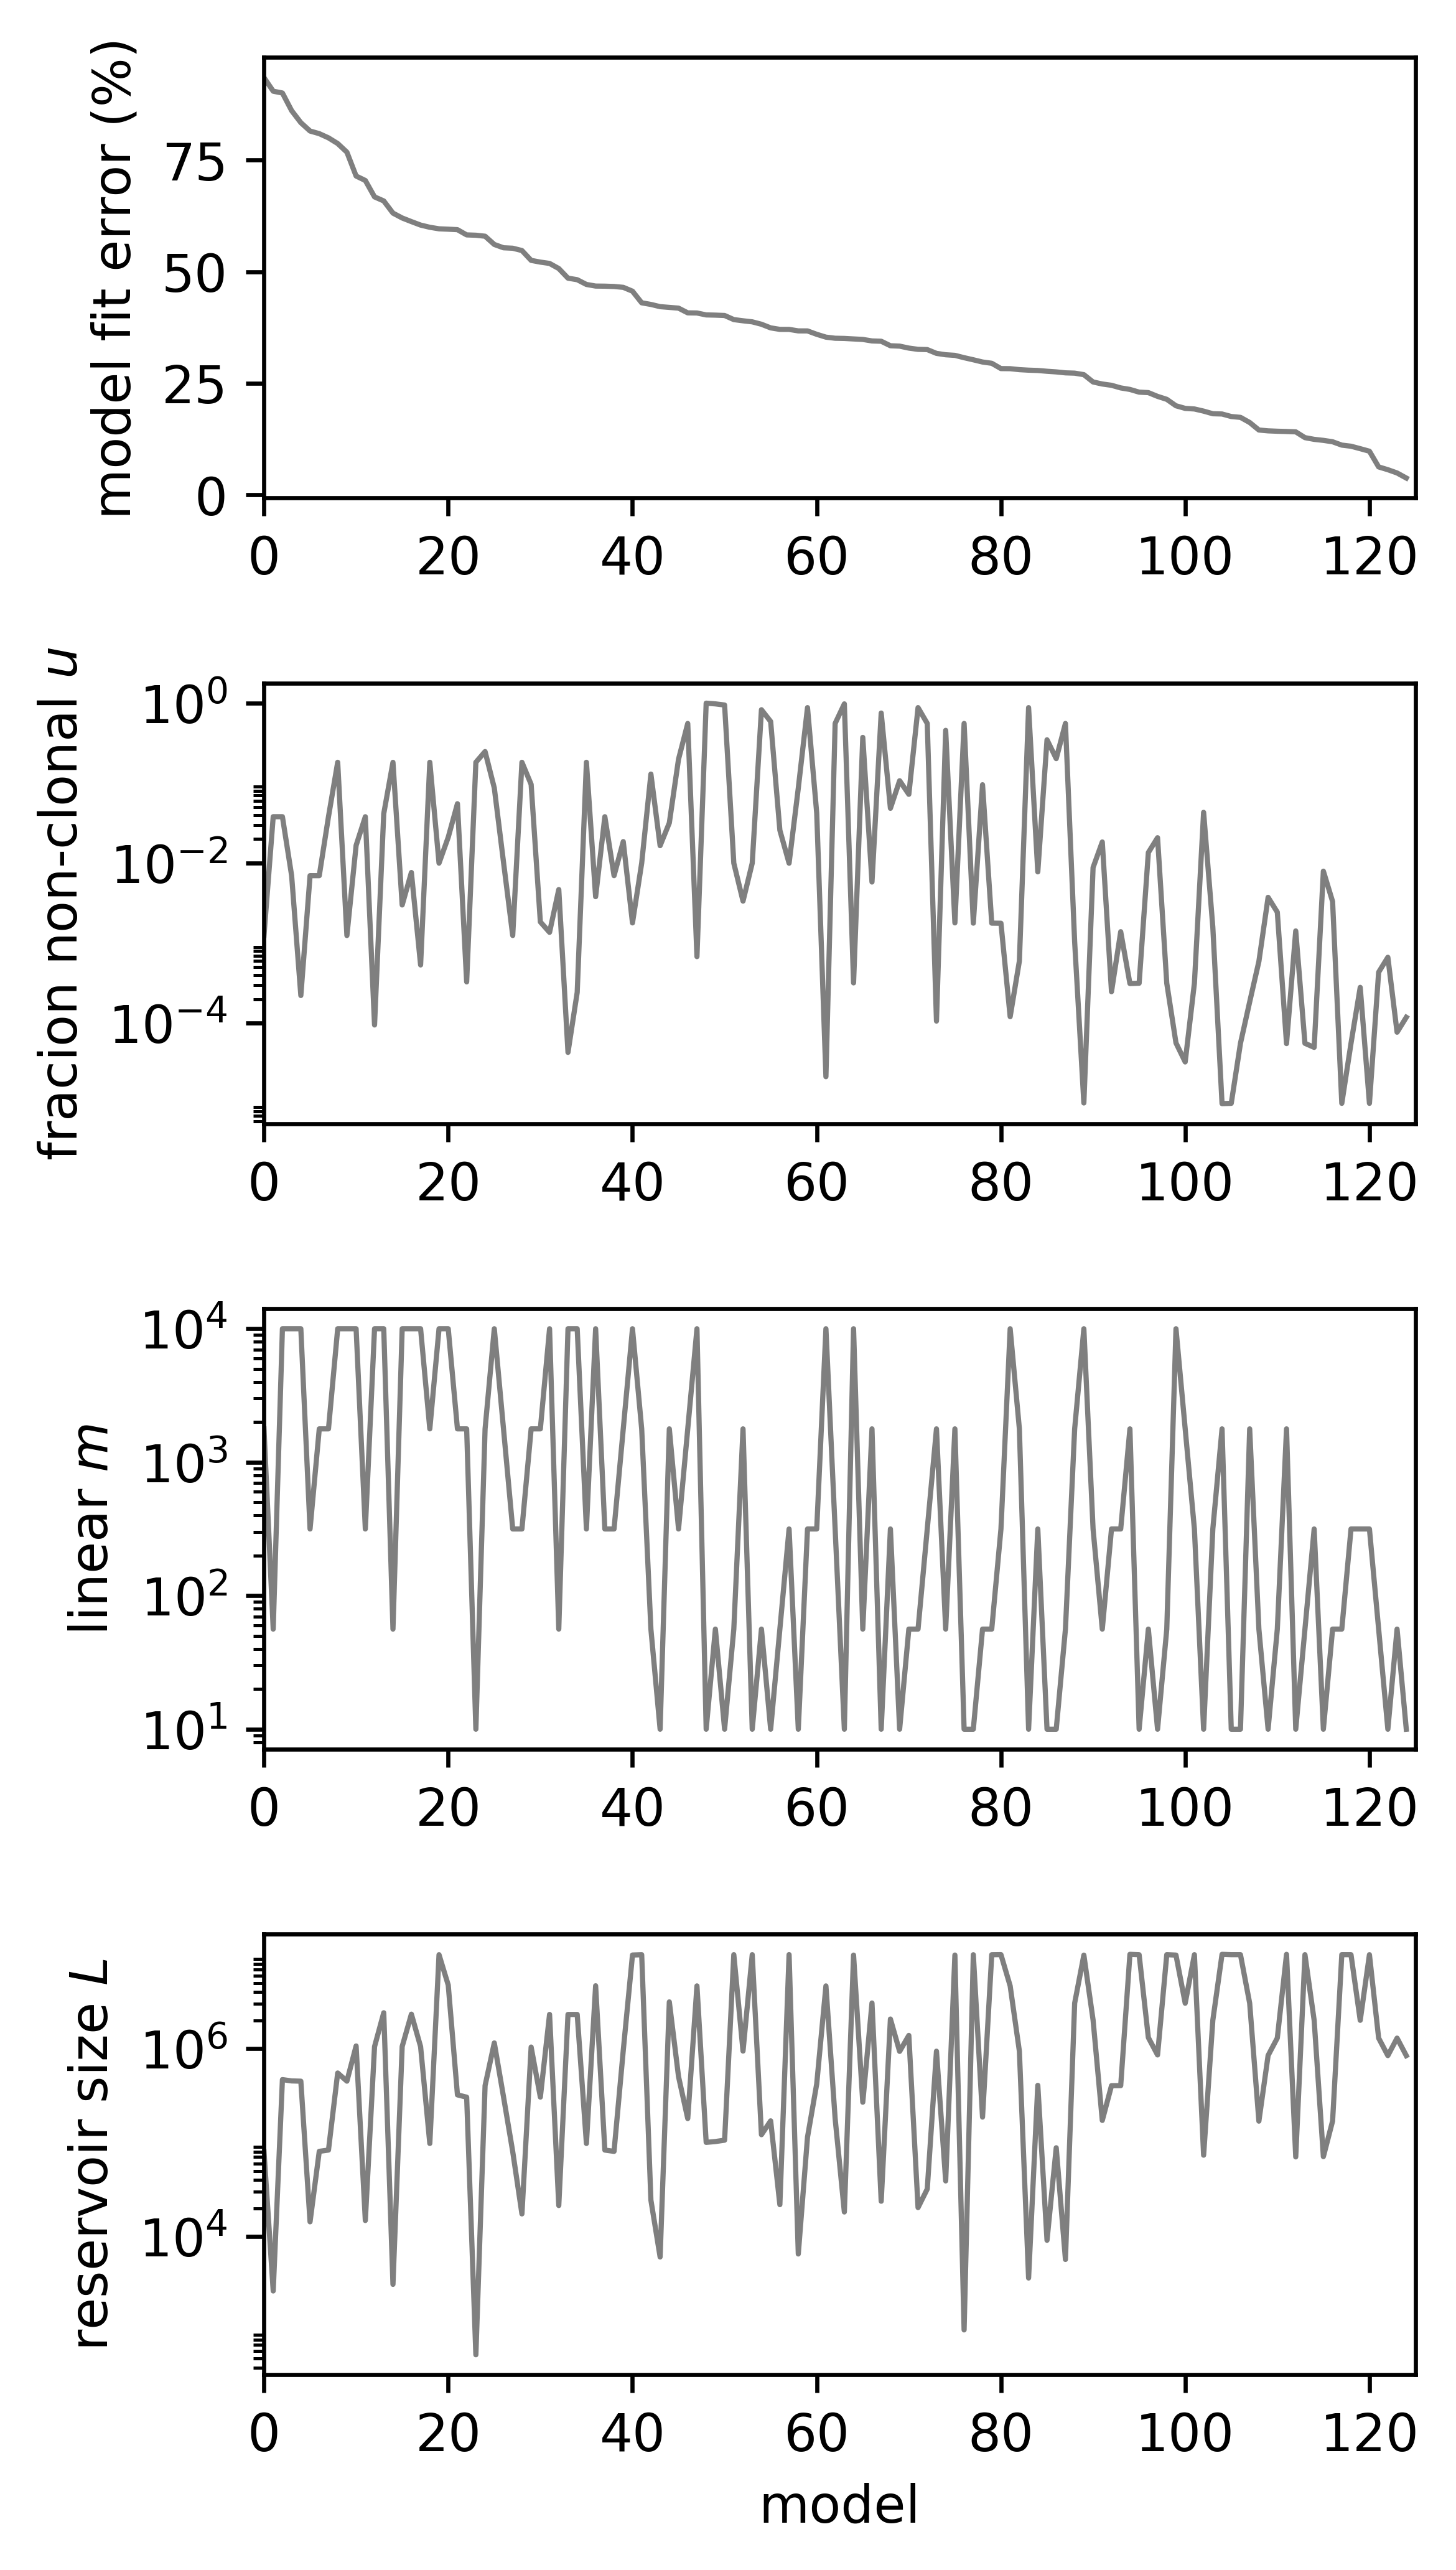

In [9]:
plt.figure(figsize=(4,7),dpi=rez)
m=1

inds=np.argsort(-np.array(err[m]))

plt.subplot(411)
plt.plot(range(len(err[m])),np.array(err[m])[inds]*100,color='k',lw=1,alpha=0.5)
plt.xlim([0,len(inds)])
plt.ylabel('model fit error (%)')
plt.subplot(412)
plt.semilogy(range(len(u[m])),np.array(u[m])[inds],color='k',lw=1,alpha=0.5)
plt.ylabel('fracion non-clonal $u$')
plt.xlim([0,len(inds)])
plt.subplot(413)
plt.semilogy(range(len(p[m])),np.array(p[m])[inds],color='k',lw=1,alpha=0.5)
plt.ylabel(xlabs[m])
plt.xlim([0,len(inds)])
plt.subplot(414)
plt.semilogy(range(len(L_list[m])),np.array(L_list[m])[inds],color='k',lw=1,alpha=0.5)
plt.ylabel('reservoir size $L$')
plt.xlabel('model')
plt.xlim([0,len(inds)])

plt.tight_layout()

plt.savefig('figures/fitsummarylines.pdf')

/Applications/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Applications/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:3355: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  U = self._random_state.random_sample(self._size)


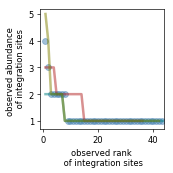

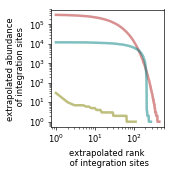

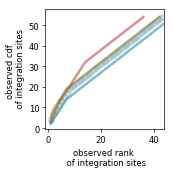

In [23]:
#compute the best model distribution and plot this for a given patient
pat=2

rez=60

ml=[]; dl=[]
for i in range(3):
    ml.append(best_m_list[i][pat])
    dl.append(ml[i].make_distribution())
    ml[i].populate_model(num_avgs=1)

fig1, ax1 = plt.subplots(figsize=(3, 3),dpi=rez)
fig2, ax2 = plt.subplots(figsize=(3, 3),dpi=rez)
fig3, ax3 = plt.subplots(figsize=(3, 3),dpi=rez)

for i in range(3):

    data_rank,data_abund,data_cdf,sim_rank,sim_abund,sim_cdf,error=model.compute_model(dl[i],pat)

    rank,abund=model.rank_model(dl[i],num_samples=ml[i].L)

    ax1.plot(sim_rank,sim_abund,lw=3,alpha=0.5,color=colorz[i])
    ax2.loglog(rank,abund,lw=3,alpha=0.5,color=colorz[i])
    ax3.plot(sim_rank,sim_cdf,lw=3,alpha=0.5,color=colorz[i])

ax1.set_xlabel('observed rank \n of integration sites')
ax1.set_ylabel('observed abundance \n of integration sites')
ax1.scatter(data_rank,data_abund,color=color_list[pat],marker=marker_list[pat],alpha=0.5,s=50)
ax1.set_xlim([-1,max(data_rank)+1])

ax2.set_xlabel('extrapolated rank \n of integration sites')
ax2.set_ylabel('extrapolated abundance \n of integration sites')
#ax2.set_ylim([0.1,1e6])
#ax2.legend(titz,fontsize=8)

ax3.set_xlabel('observed rank \n of integration sites')
ax3.set_ylabel('observed cdf \n of integration sites')
ax3.set_xlim([-1,max(data_rank)+1])
ax3.scatter(data_rank,data_cdf,color=color_list[pat],marker=marker_list[pat],s=50,alpha=0.25)

fig1.tight_layout()
fig1.savefig('figures/rankabund_fit'+str(pat)+'.pdf')

fig2.tight_layout()
fig2.savefig('figures/rankabund_extrap'+str(pat)+'.pdf')

fig3.tight_layout()
fig3.savefig('figures/cdf_fit'+str(pat)+'.pdf')



/Applications/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Applications/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:3355: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  U = self._random_state.random_sample(self._size)


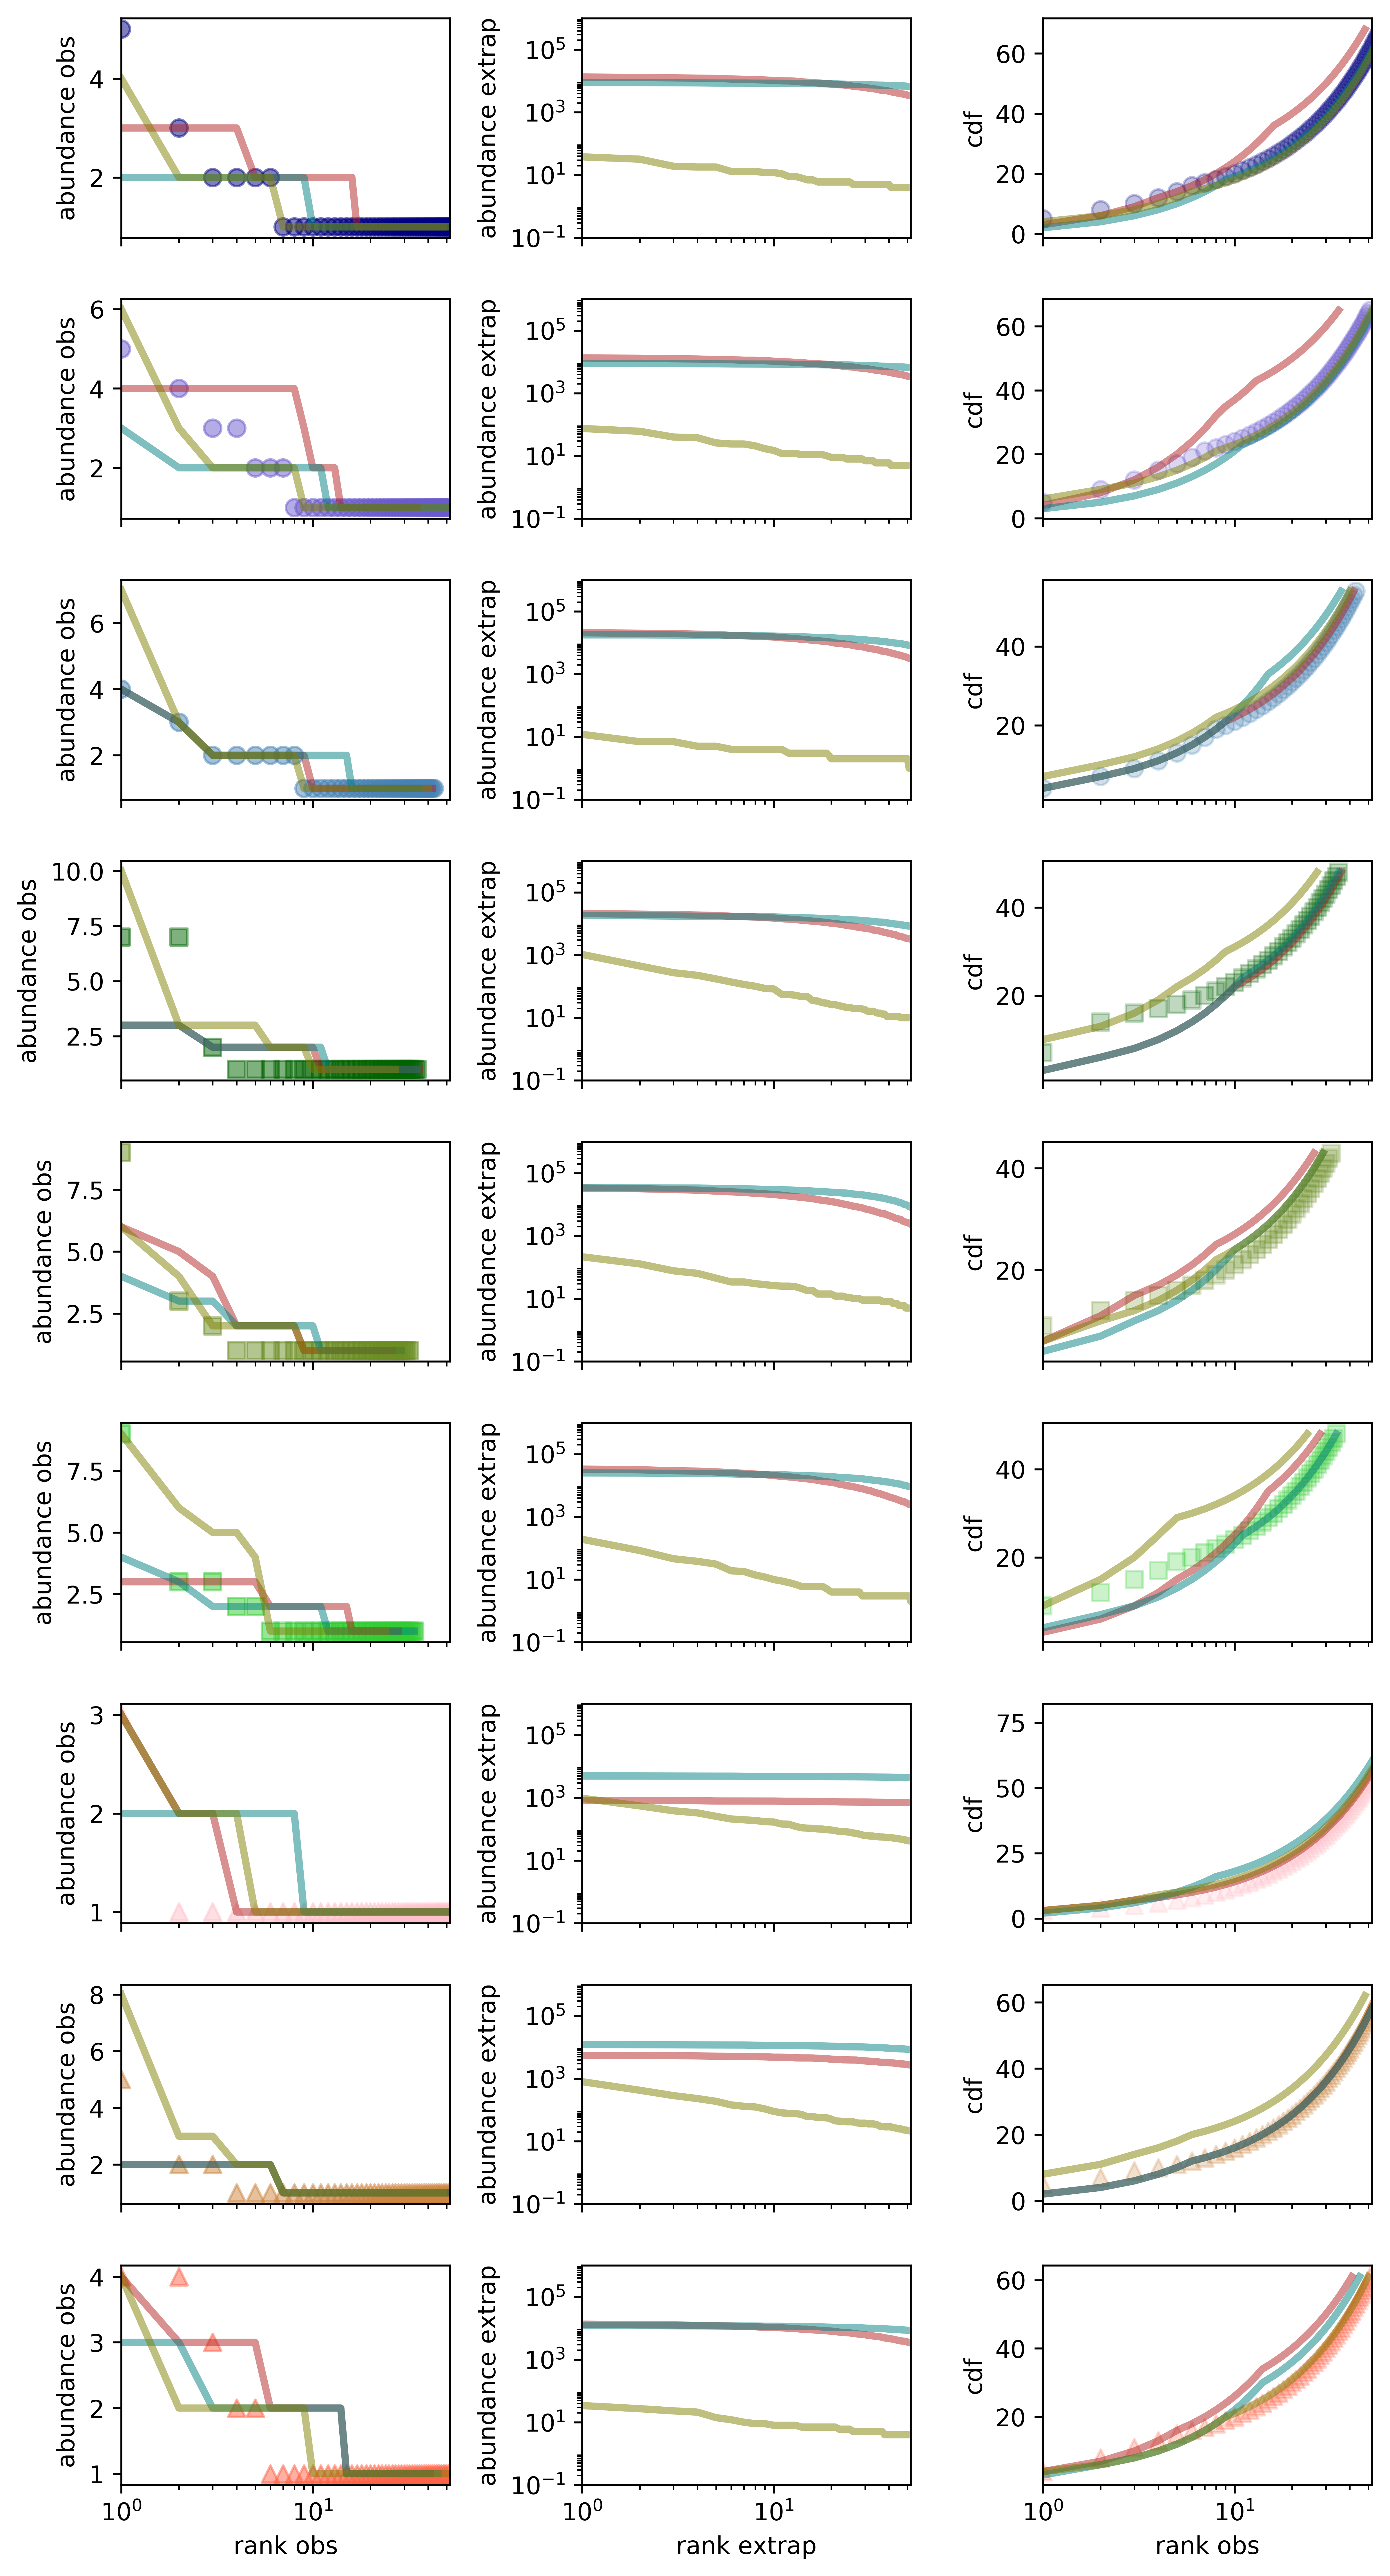

In [14]:
#make the supplemental figure with all fits
fig, ax = plt.subplots(9,3,sharex=True,figsize=(8, 15),dpi=rez)
for pat in range(9):

    ml=[]; dl=[]
    for i in range(3):
        ml.append(best_m_list[i][pat])
        dl.append(ml[i].make_distribution())
        ml[i].populate_model(num_avgs=1)

    for i in range(3):

        data_rank,data_abund,data_cdf,sim_rank,sim_abund,sim_cdf,error=model.compute_model(dl[i],pat)

        rank,abund=model.rank_model(dl[i],num_samples=ml[i].L)

        ax[pat][0].plot(sim_rank,sim_abund,lw=3,alpha=0.5,color=colorz[i])
        ax[pat][1].loglog(rank,abund,lw=3,alpha=0.5,color=colorz[i])
        ax[pat][2].plot(sim_rank,sim_cdf,lw=3,alpha=0.5,color=colorz[i])

    ax[pat][0].set_ylabel('abundance obs')
    ax[pat][0].scatter(data_rank,data_abund,color=color_list[pat],marker=marker_list[pat],alpha=0.5,s=50)
    ax[pat][0].set_xlim([-1,max(data_rank)+1])

    ax[pat][1].set_ylabel('abundance extrap')
    ax[pat][1].set_ylim([0.1,1e6])
    ax[pat][1].set_xlim([1,1e4])
    #ax2.legend(titz,fontsize=8)

    ax[pat][2].set_ylabel('cdf')
    ax[pat][2].set_xlim([-1,max(data_rank)+1])
    ax[pat][2].scatter(data_rank,data_cdf,color=color_list[pat],marker=marker_list[pat],s=50,alpha=0.25)

ax[8][0].set_xlabel('rank obs')
ax[8][1].set_xlabel('rank extrap')
ax[8][2].set_xlabel('rank obs')

plt.tight_layout()
plt.savefig('figures/summary_all_fits.pdf')


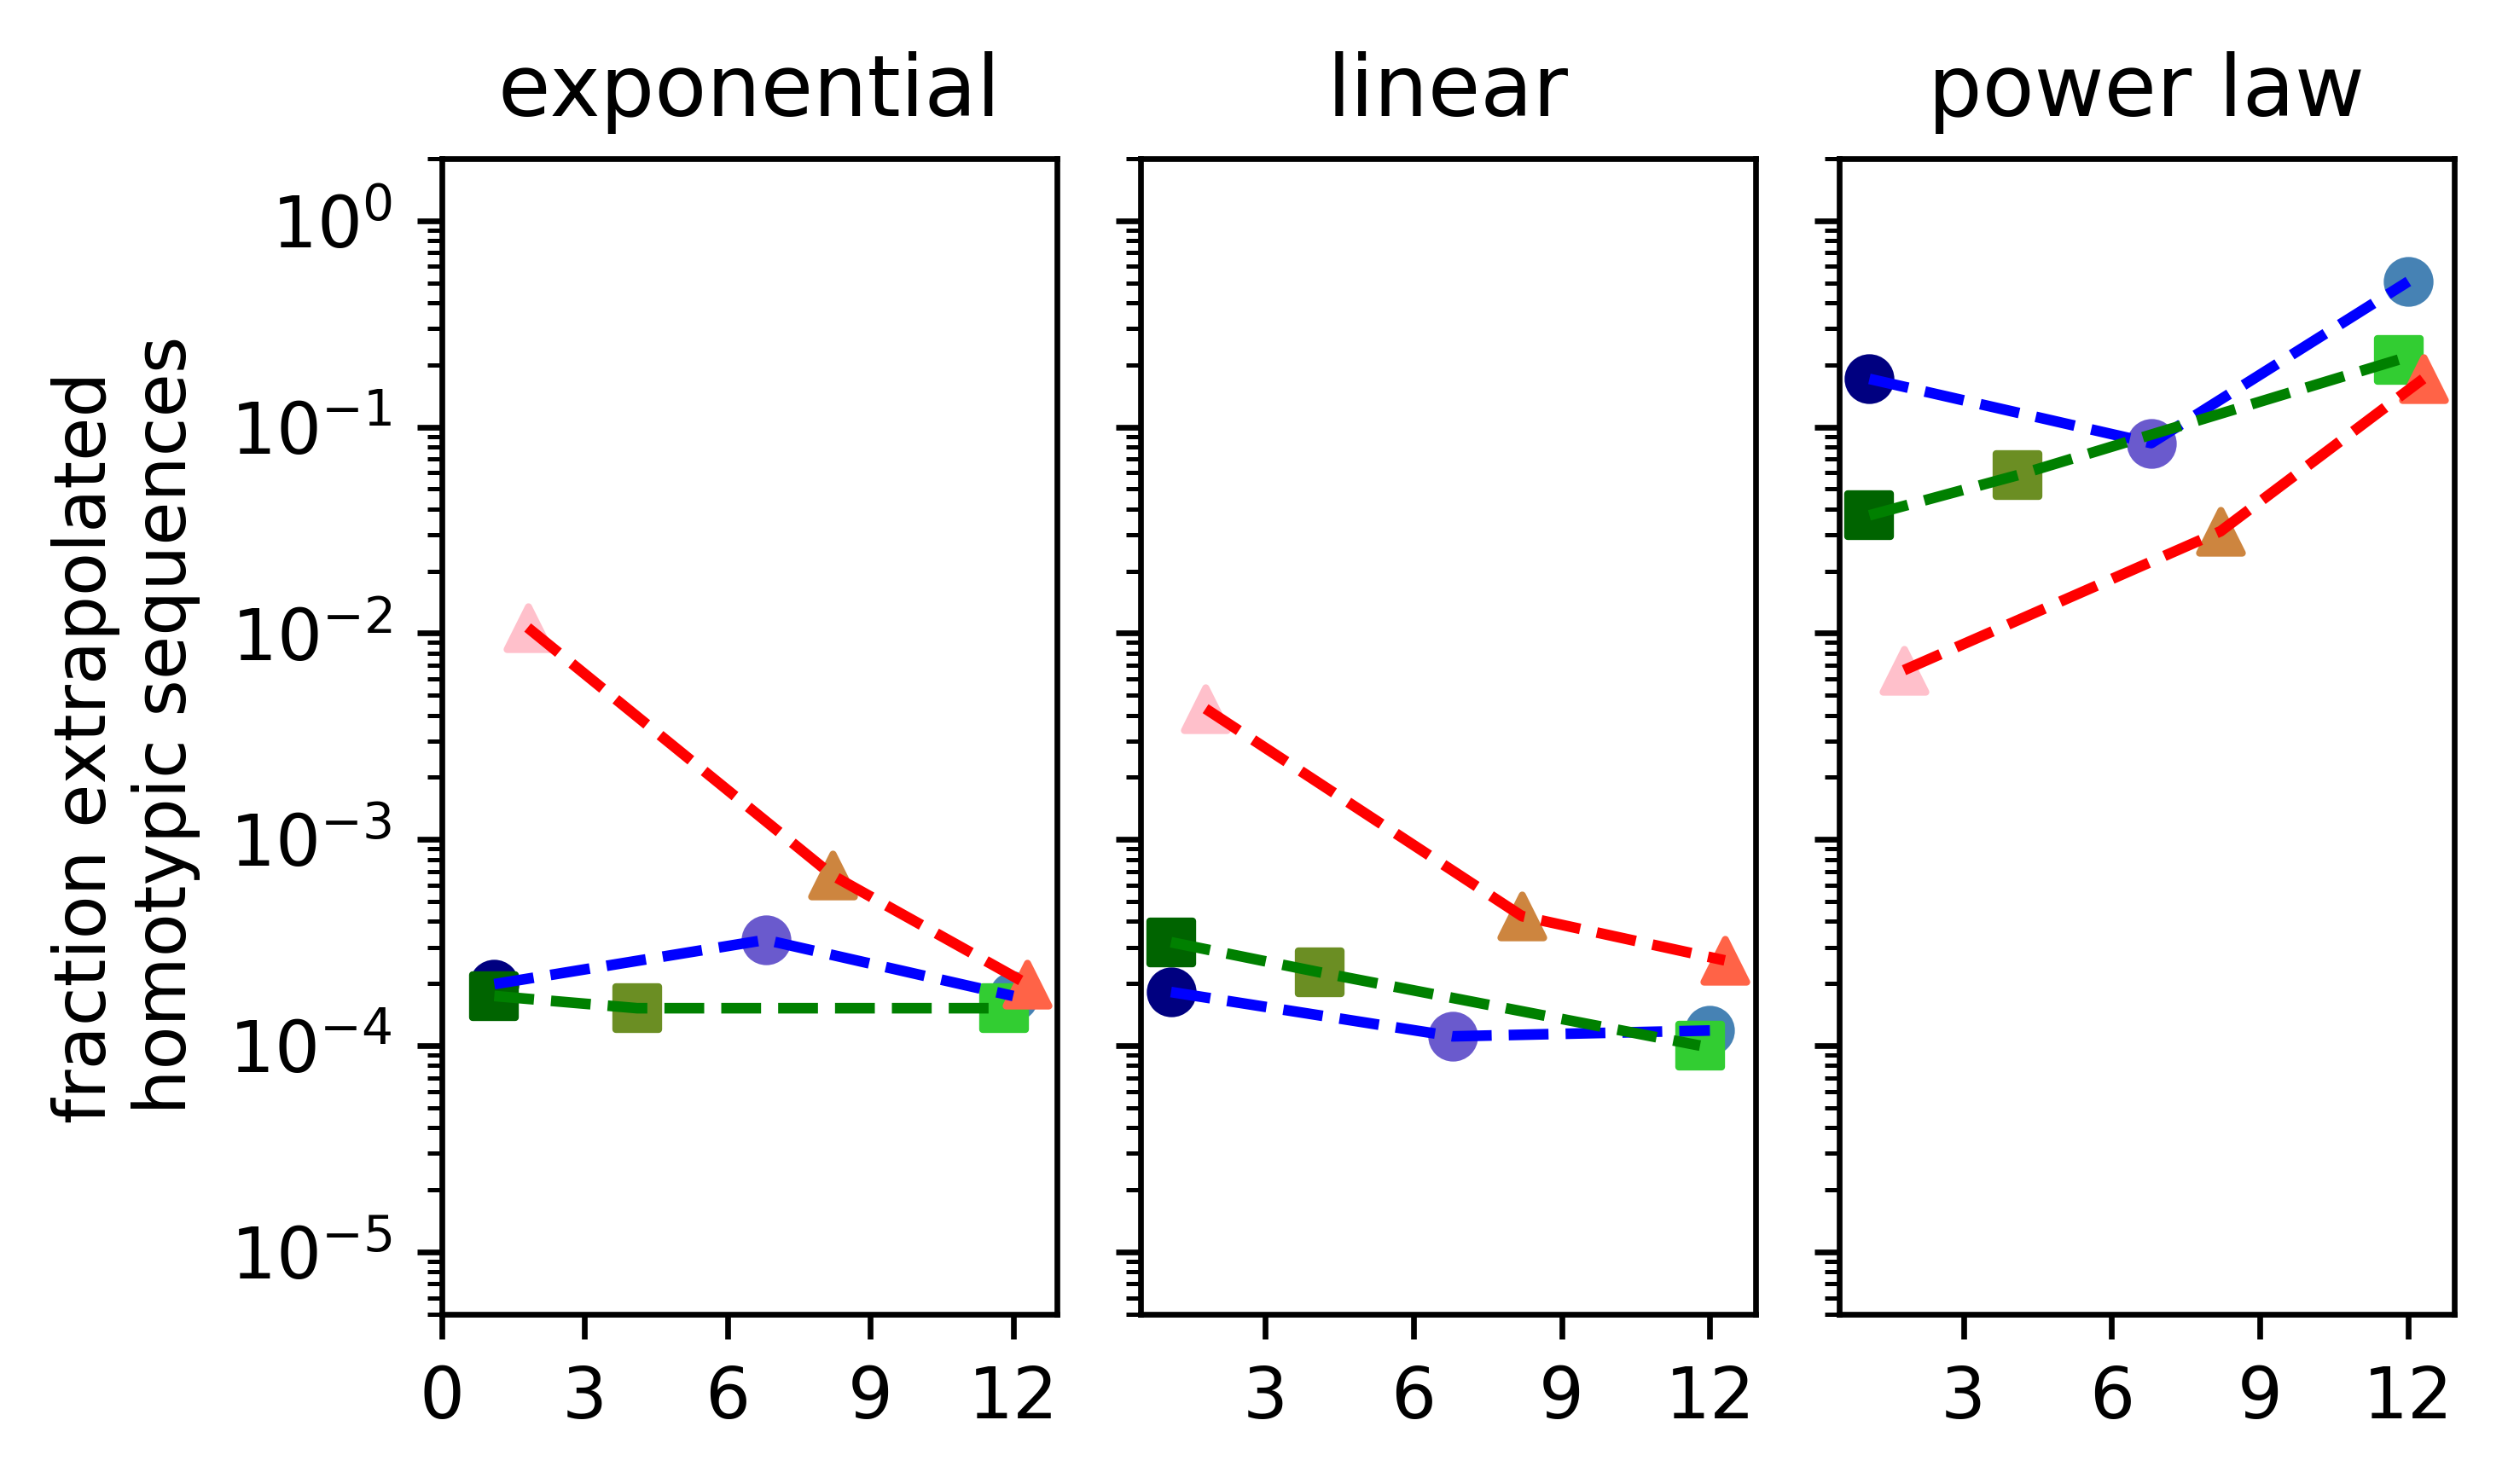

In [15]:
fig, ax = plt.subplots(1,3,figsize=(5, 3),dpi=rez,sharex=True,sharey=True)
best_u=[[],[],[]]
for pat in patients:
    for i in range(3):
        model=best_m_list[i][pat]

        uu=model.ufrac

        ax[i].scatter(t_list[pat],uu,marker=marker_list[pat],color=color_list[pat])
        
        best_u[i].append(uu)

if len(best_u[1])==9:
    for i in range(3):
        ax[i].semilogy(t_list[:3],best_u[i][:3],ls='--',color='blue')
        ax[i].plot(t_list[3:6],best_u[i][3:6],ls='--',color='green')
        ax[i].plot(t_list[6:],best_u[i][6:],ls='--',color='red')
        ax[i].set_title(titz[i])
        ax[i].set_ylim([5e-6,2])
ax[0].set_ylabel('fraction extrapolated \n homotypic sequences') 
#ax[1].set_xlabel('time on ART (years)')   
ax[0].set_xticks(np.arange(0,13,3))
#ax[0].set_yscale('log')
plt.tight_layout()
plt.savefig('figures/unique_extrap.pdf')

In [16]:
#print some summary statistics for best models

for m in range(3):

    print(xlabs[m])
    print(r'time (yrs) & best param & reservoir size L & max rank & rank1 frac & unique frac & 90% rank & 99% rank \\')
    for pat in range(9):
        model = best_m_list[m][pat]
        
        dist = model.make_distribution()
        print(t_list[pat],'&       ',model.parameter,'&',model.L,'&    ',len(dist),
              '&    ',max(dist)/sum(dist),'&',sum(dist==1)/sum(dist),
              '&', np.where(np.cumsum(dist)>(0.9*sum(dist)))[0][0]/len(dist),
              '&', np.where(np.cumsum(dist)>(0.99*sum(dist)))[0][0]/len(dist), r'\\')


exponential $\beta$
time (yrs) & best param & reservoir size L & max rank & rank1 frac & unique frac & 90% rank & 99% rank \\
1.1 &        0.0268269579528 & 503127.194377 &     454 &     0.026467037892 & 0.000198756897098 & 0.187224669604 & 0.378854625551 \\
6.8 &        0.0268269579528 & 503191.194377 &     518 &     0.0264636715961 & 0.000325919852797 & 0.164092664093 & 0.332046332046 \\
12 &        0.0372759372031 & 574232.210877 &     367 &     0.0365851115781 & 0.000174145577531 & 0.16621253406 & 0.33514986376 \\
1.1 &        0.0372759372031 & 574232.210877 &     367 &     0.0365851115781 & 0.000174145577531 & 0.16621253406 & 0.33514986376 \\
4.1 &        0.0517947467923 & 658103.903445 &     301 &     0.0504701099274 & 0.000151951689508 & 0.146179401993 & 0.295681063123 \\
11.8 &        0.0517947467923 & 658103.903445 &     301 &     0.0504701099274 & 0.000151951689508 & 0.146179401993 & 0.295681063123 \\
1.8 &        0.00268269579528 & 296824.270994 &     5648 &     0.0026539297

/Applications/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [17]:
r90=[[],[],[]]; r99=[[],[],[]];
for m in range(3):
    for pat in range(9):
        model = best_m_list[m][pat]
        
        dist = model.make_distribution()
        
        r90[m].append(np.where(np.cumsum(dist)>(0.9*sum(dist)))[0][0]/len(dist)*100)
        r99[m].append(np.where(np.cumsum(dist)>(0.99*sum(dist)))[0][0]/len(dist)*100)
        


/Applications/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


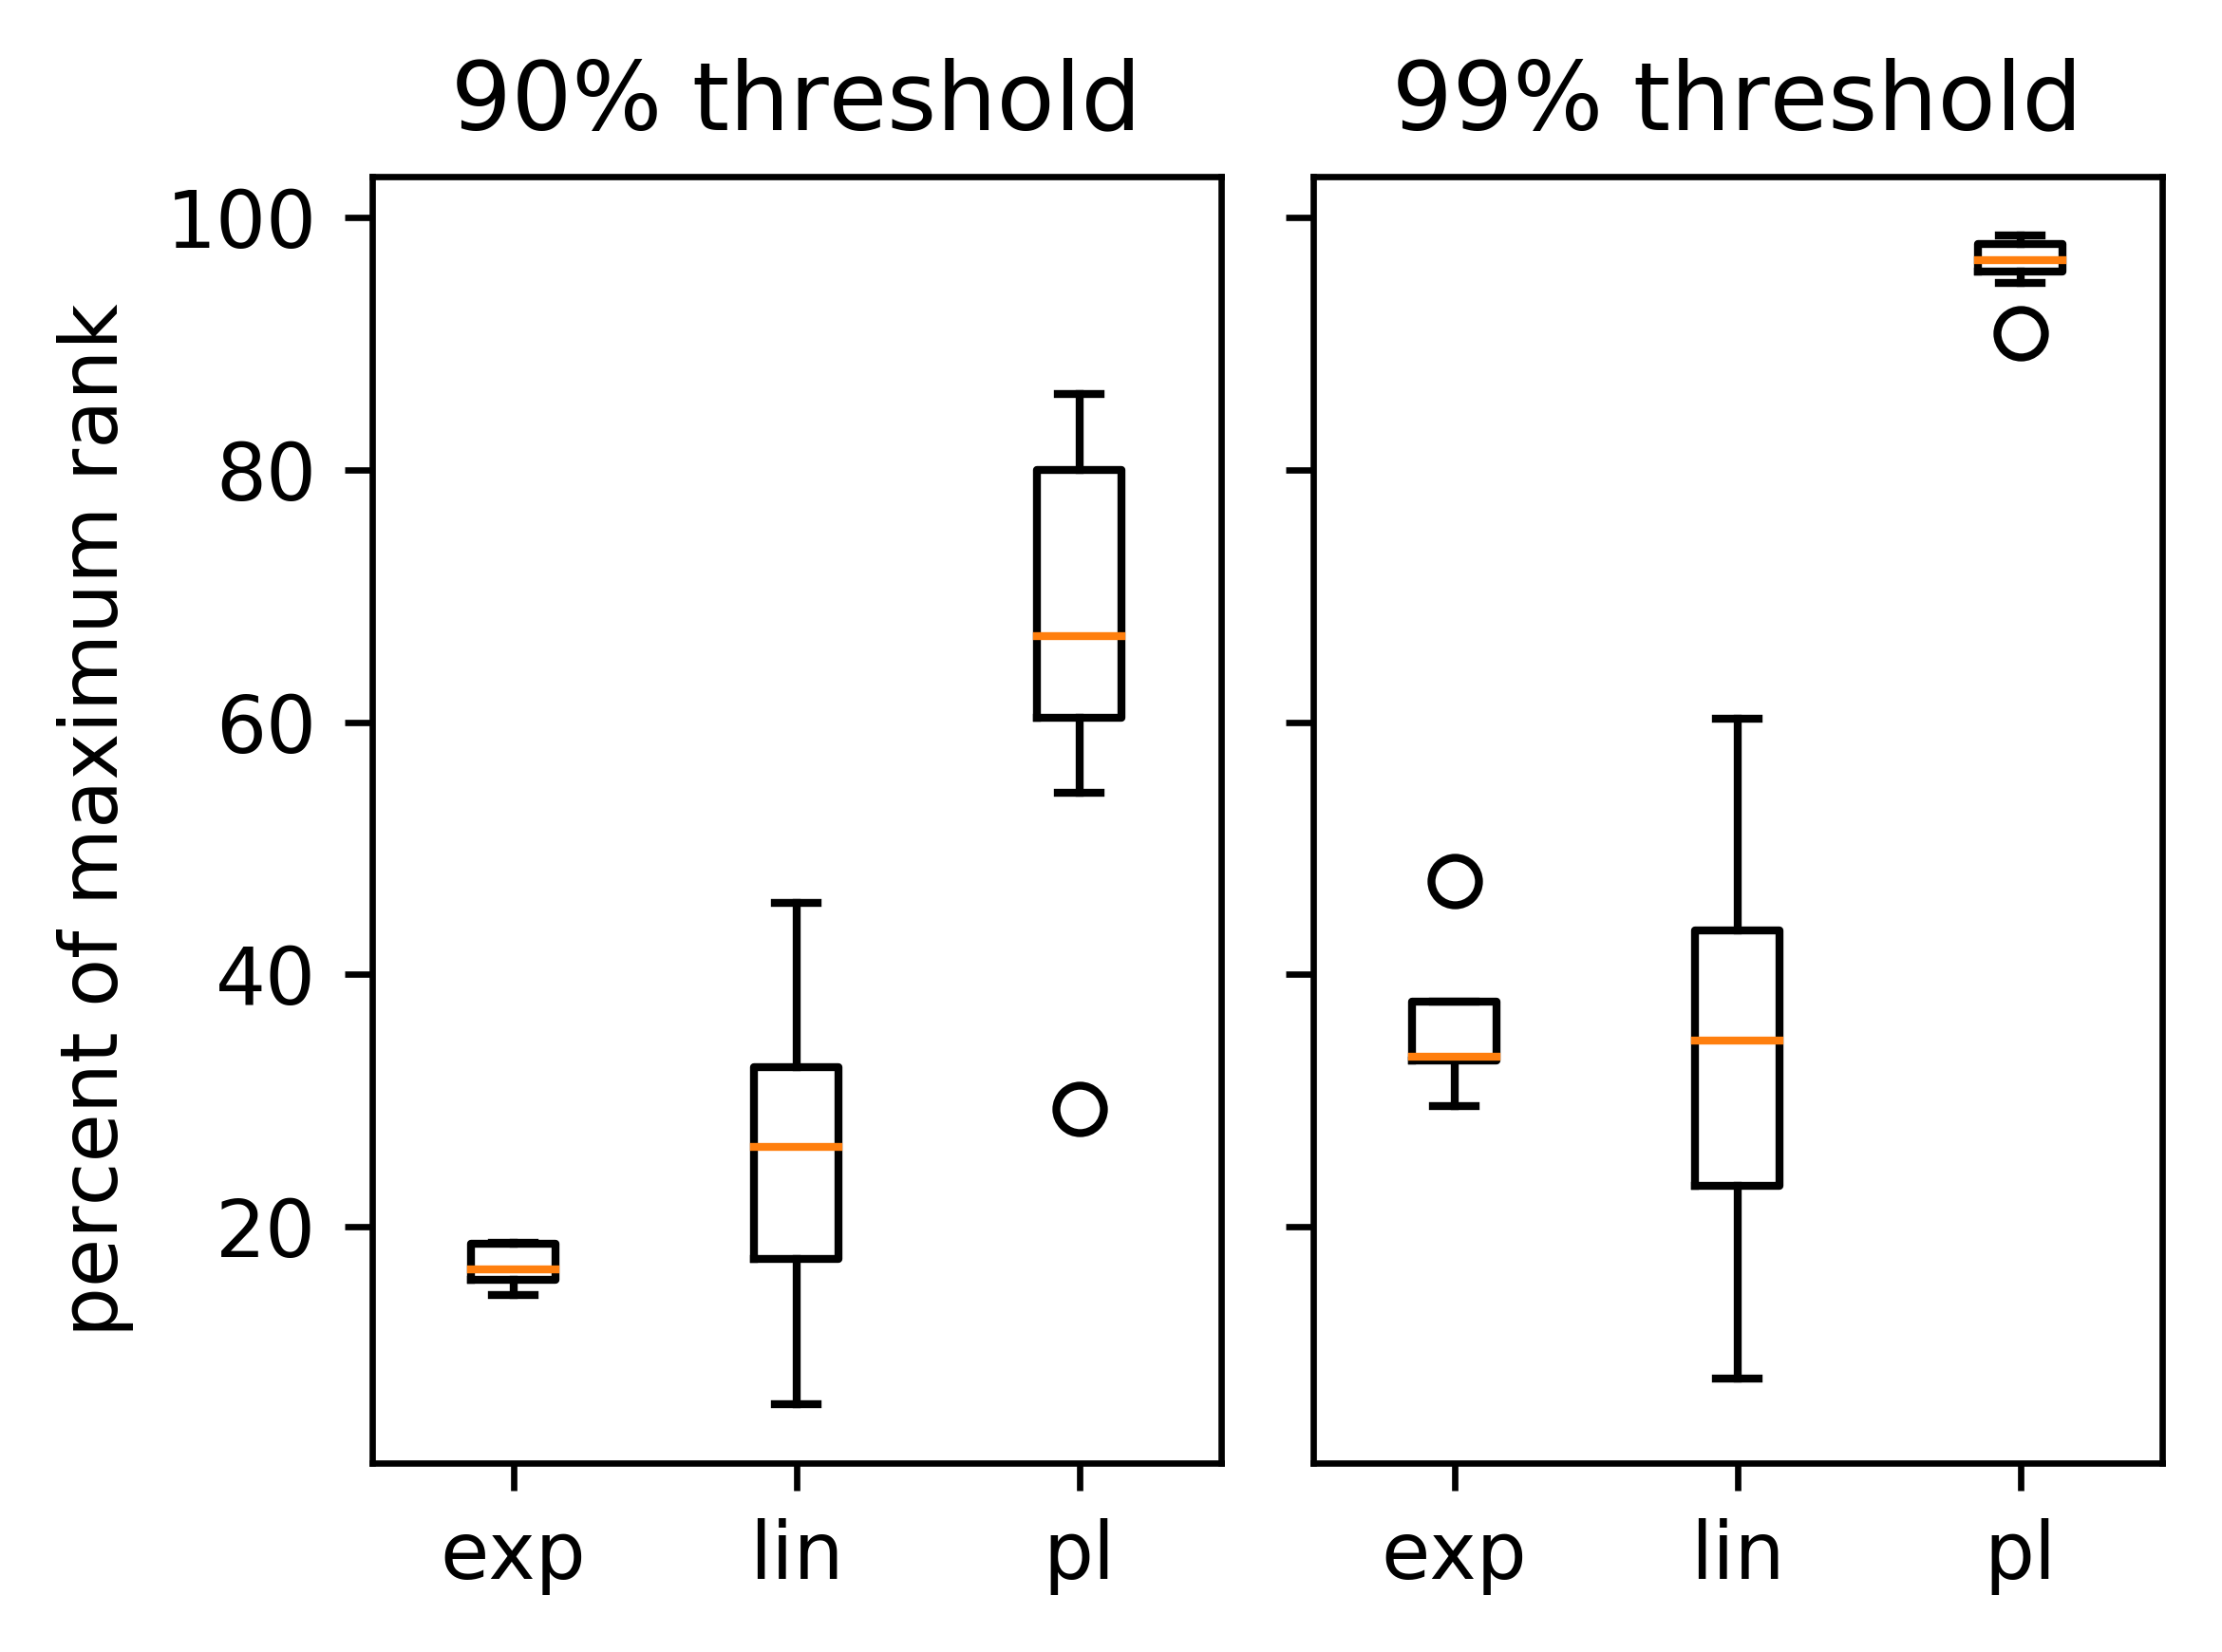

In [18]:
fig,ax=plt.subplots(1,2,figsize=(4,3),sharey=True,sharex=True,dpi=rez)
ax[0].boxplot(r90)
ax[1].boxplot(r99)

ax[0].set_xticklabels(['exp','lin','pl'])
ax[0].set_ylabel('percent of maximum rank')
ax[0].set_title('90% threshold')
ax[1].set_title('99% threshold')

plt.tight_layout()
plt.savefig('figures/boxplots.pdf')

In [19]:
#now rarefaction

def rarefact(true_clones):

    R=len(true_clones)
    N=sum(true_clones)

    Rn=np.zeros(R)
    nl=np.arange(1,R+1)

    for n in nl:
        ss=[]
        for j in range(len(true_clones)):
            ss.append(comb(N-true_clones[j],n))

        Rn[n-1]=(R - sum(ss)/comb(N,n))
    
    return nl,Rn

#species accumulation
def accumulate(dist,max_s):
    s_list=[]
    s=0
    curve=[]
    while s<max_s:
        draw = sample_distribution(dist/sum(dist),1)

        if draw not in s_list:
            s+=1

        s_list.append(draw)
        curve.append(s)
    
    return np.arange(1,len(curve)+1),np.array(curve)

#newer one
def rarefaction(rank,abundance,num_samples):

    R=len(abundance)
    L=sum(abundance)

    r_list=np.zeros(num_samples)
    n_list=range(1,num_samples+1)
    for n in n_list:
        ss=0 #the sum
        for j in range(R):
            ss+=comb(L-abundance[j],n)
            
        r_list[n-1]=R-ss/comb(L,n)
    return n_list,r_list

#function that calculates rarefaction curve based on rank and abundance data
def rarefaction_approx(rank,abundance,num_samples):

    R=len(abundance)
    L=sum(abundance)

    r_list=np.zeros(num_samples)
    n_list=range(1,num_samples+1)
    for n in n_list:
        r_list[n-1]=R-np.sum((1-abundance/L)**n)
    return n_list,r_list

#generate random samples from distribution
def sample_distribution(dist,num_samples):
    custm = stats.rv_discrete(name='custm', values=(np.arange(1,len(dist)+1), dist/sum(dist)))
    sim_samples = custm.rvs(size=num_samples)
    return sim_samples


/Applications/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


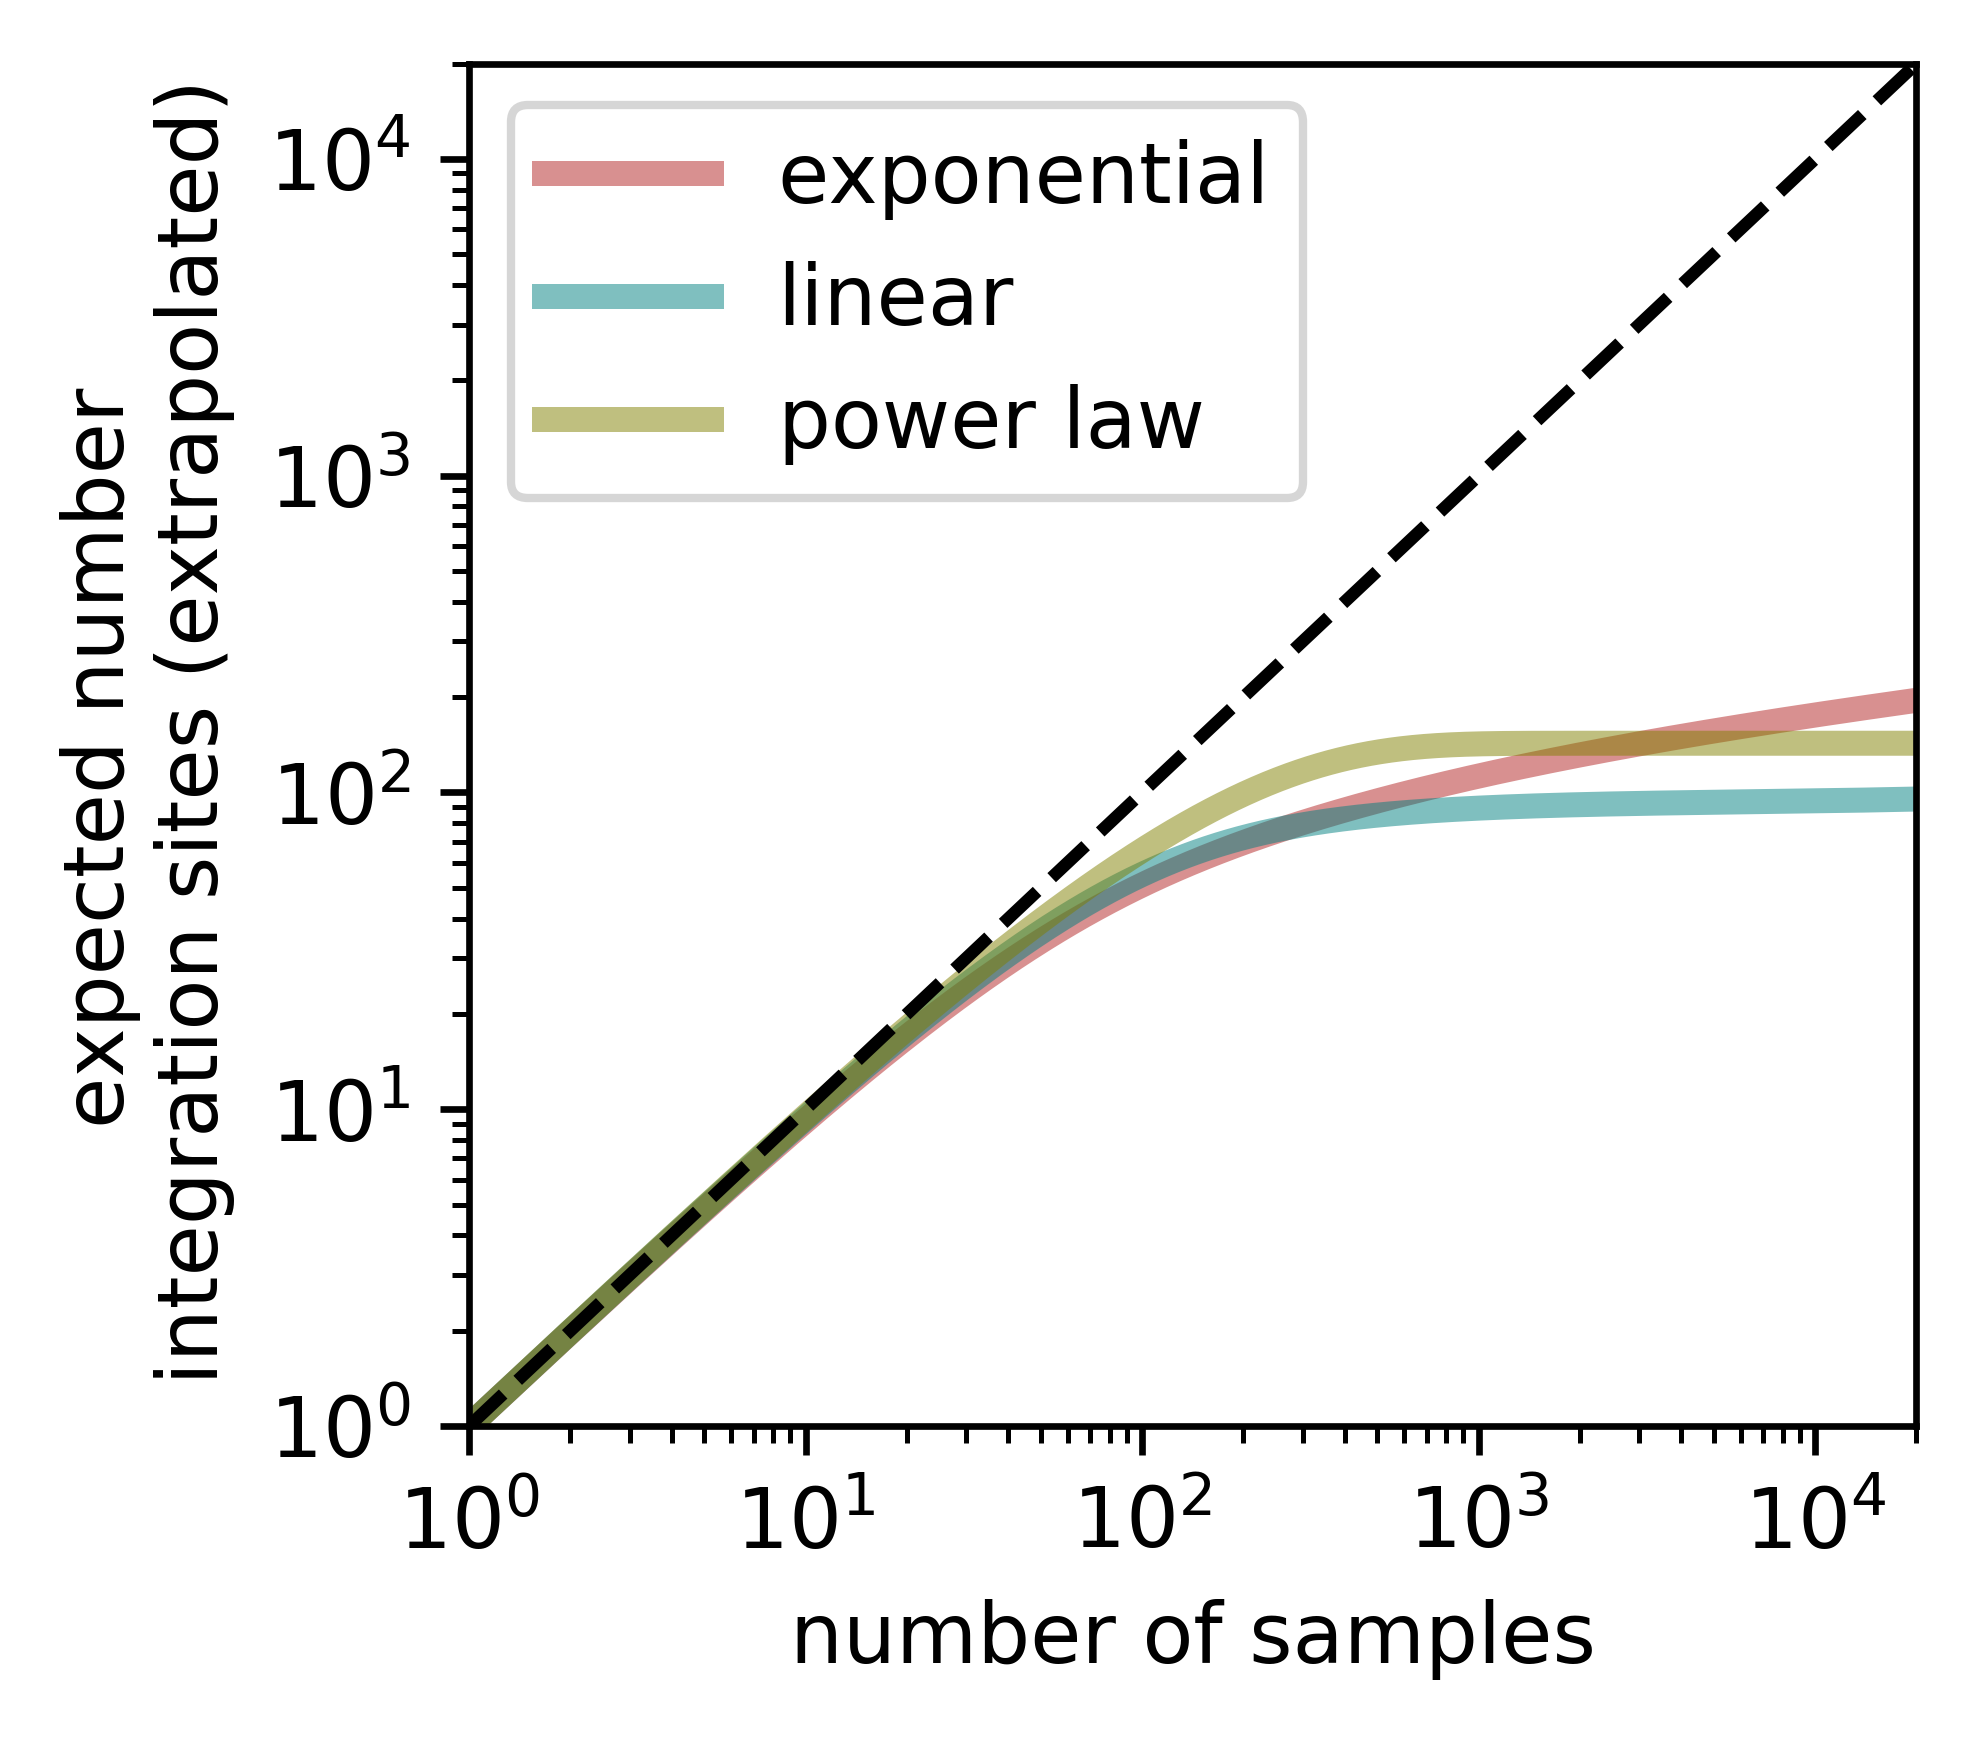

In [20]:
#show examples of species accumulation and rarefaction

for pat in [2]:

    plt.figure(figsize=(3.4,3),dpi=rez)
    
    for m in range(3):
        model = best_m_list[m][pat]
        
        dist = model.make_distribution()
        max_s=20000

        #for i in range(10):
        #    samples, species = accumulate(dist,max_s)
        #    plt.plot(samples,species,color=colorz[m],alpha=0.3,lw=1)

        samples=50
        exp_samples, exp_species=rarefaction_approx(samples,dist,max_s)
        plt.loglog(exp_samples,exp_species,lw=3,color=colorz[m],alpha=0.5)
        plt.xlim([0,max_s])
        plt.ylim([0,max_s])
    
    plt.legend(['exponential','linear','power law'],fontsize=10,loc=2)

    plt.plot(np.linspace(1,max_s,5),np.linspace(1,max_s,5),ls='--',color='black')
    plt.xlabel('number of samples')
    plt.ylabel('expected number \n integration sites (extrapolated)')
    
    plt.tight_layout()
    plt.savefig('figures/rarefaction_example_extrap'+str(pat)+'.pdf')
    
